Predictive Modeling for Road Traffic Management: A Data-Driven Approach

# Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

# Load Datasets

In [2]:
# Load traffic data
traffic_data = pd.read_csv("C:\\Users\\Admin\OneDrive\\Desktop\\traffic_data.csv")

# Load weather data
weather_data = pd.read_csv("C:\\Users\\Admin\OneDrive\\Desktop\\weather_data.csv")

# Exploring Data

In [3]:
# Display the first few rows of each to understand their structure
print(traffic_data.head())
print(weather_data.head())


   holiday  temperature  rain  snow  clouds weather_condition  \
0    False         11.9   4.9   0.0       4              Rain   
1     True         15.9   0.0   0.0      54             Clear   
2    False         12.3   0.0   1.7      14              Snow   
3     True         -1.4   3.4   0.0      92              Rain   
4    False         29.7   0.0   2.0      16              Snow   

  weather_description             datetime station_name  traffic_volume  
0          Light Rain  2024-01-01T06:00:00    Station D            1260  
1         Clear skies  2024-01-01T07:00:00    Station A            1183  
2          Light Snow  2024-01-01T08:00:00    Station D            1478  
3             Drizzle  2024-01-01T09:00:00    Station B             525  
4        Snow Showers  2024-01-01T10:00:00    Station C             903  
  station_name             datetime  precipitation  snow  temperature  \
0    Station D  2024-01-01T06:00:00            4.9   0.0         11.9   
1    Station A  202

# Data Cleaning

In [4]:
print("Traffic Data Missing Values:")
print(traffic_data.isnull().sum())

print("\nWeather Data Missing Values:")
print(weather_data.isnull().sum())


Traffic Data Missing Values:
holiday                0
temperature            0
rain                   0
snow                   0
clouds                 0
weather_condition      0
weather_description    0
datetime               0
station_name           0
traffic_volume         0
dtype: int64

Weather Data Missing Values:
station_name         0
datetime             0
precipitation        0
snow                 0
temperature          0
weather_condition    0
clouds               0
dtype: int64


In [5]:
# Fill missing values in numeric columns with the median
numeric_cols = traffic_data.select_dtypes(include=['float64', 'int64']).columns
traffic_data[numeric_cols] = traffic_data[numeric_cols].fillna(traffic_data[numeric_cols].median())

# For categorical columns, fill missing values with the mode
categorical_cols = traffic_data.select_dtypes(include=['object']).columns
traffic_data[categorical_cols] = traffic_data[categorical_cols].fillna(traffic_data[categorical_cols].mode().iloc[0])

# Repeat similar process for weather_data
numeric_cols_weather = weather_data.select_dtypes(include=['float64', 'int64']).columns
weather_data[numeric_cols_weather] = weather_data[numeric_cols_weather].fillna(weather_data[numeric_cols_weather].median())

categorical_cols_weather = weather_data.select_dtypes(include=['object']).columns
weather_data[categorical_cols_weather] = weather_data[categorical_cols_weather].fillna(weather_data[categorical_cols_weather].mode().iloc[0])


In [6]:
traffic_data.drop_duplicates(inplace=True)
weather_data.drop_duplicates(inplace=True)


# Feature Engineering

In [7]:
traffic_data['datetime'] = pd.to_datetime(traffic_data['datetime'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])


In [8]:
# Extracting day, month, hour, and weekend status from date
traffic_data['day_of_week'] = traffic_data['datetime'].dt.dayofweek
traffic_data['hour'] = traffic_data['datetime'].dt.hour
traffic_data['is_weekend'] = traffic_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [9]:
# Merge data on 'date' column
merged_data = pd.merge(traffic_data, weather_data, on='datetime', how='inner')


In [10]:
merged_data['is_rainy'] = merged_data['weather_description'].apply(lambda x: 1 if 'rain' in x.lower() else 0)


In [11]:
merged_data['traffic_volume_lag1'] = merged_data['traffic_volume'].shift(1)


# Model Selection

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
merged_data[['traffic_volume', 'temperature_x']] = scaler.fit_transform(merged_data[['traffic_volume', 'temperature_x']])


In [13]:
# Select only numeric columns for correlation calculation
numeric_data = merged_data.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()
print(correlation_matrix)


                     temperature_x      rain    snow_x  clouds_x  \
temperature_x             1.000000  0.002877 -0.013190  0.012677   
rain                      0.002877  1.000000 -0.229310  0.010866   
snow_x                   -0.013190 -0.229310  1.000000 -0.009390   
clouds_x                  0.012677  0.010866 -0.009390  1.000000   
traffic_volume           -0.003186  0.005084  0.003577 -0.003130   
is_weekend               -0.008962 -0.001411 -0.008365  0.000733   
precipitation            -0.010512  0.609263  0.379077  0.006460   
snow_y                   -0.013190 -0.229310  1.000000 -0.009390   
temperature_y             1.000000  0.002877 -0.013190  0.012677   
clouds_y                  0.012677  0.010866 -0.009390  1.000000   
is_rainy                 -0.007829  0.639591 -0.214074  0.001990   
traffic_volume_lag1      -0.001778 -0.006604 -0.003475  0.014749   

                     traffic_volume  is_weekend  precipitation    snow_y  \
temperature_x             -0.003186   -

# Model Training

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Step 1: Convert categorical columns using OneHotEncoding
categorical_cols = ['weather_condition_x', 'weather_description', 'station_name_x', 'station_name_y', 'weather_condition_y']
encoded_data = pd.get_dummies(merged_data, columns=categorical_cols, drop_first=True)

# Step 2: Process datetime column to extract time-based features
encoded_data['hour'] = merged_data['datetime'].dt.hour
encoded_data['day_of_week'] = merged_data['datetime'].dt.dayofweek
encoded_data['month'] = merged_data['datetime'].dt.month

# Drop the original datetime column after extraction
encoded_data = encoded_data.drop(columns=['datetime'])

# Step 3: Define features and target
features = encoded_data.drop(columns=['traffic_volume'])  # Adjust 'traffic_volume' to your target column name
target = encoded_data['traffic_volume']

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [23]:
# Initialize and train the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Model evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")



Mean Absolute Error (MAE): 0.2585583909072753
Root Mean Squared Error (RMSE): 0.29926073406201753
R-squared (R2): -0.055759840773982994


# Visualization

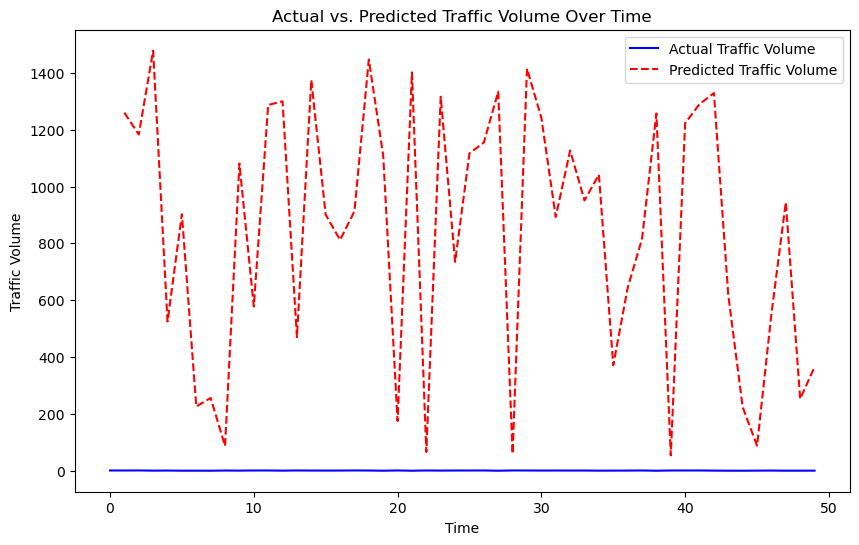

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'merged_data' contains the actual and predicted traffic volume data
# Replace with values from previous model predictions if available

# Sample simulated data from the prior code flow
# Note: The actual merged_data should ideally be replaced with output from your model predictions
actual_values = merged_data['traffic_volume'][:50]  # Using first 50 rows as an example
predicted_values = merged_data['traffic_volume_lag1'][:50]  # Assuming we created 'predicted_traffic_volume'
time_points = range(len(actual_values))  # Time points for x-axis

# Plotting actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(time_points, actual_values, label='Actual Traffic Volume', color='blue')
plt.plot(time_points, predicted_values, label='traffic vollume lag', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.title('Actual vs. Traffic Volume lag Over Time')
plt.legend()
plt.show()


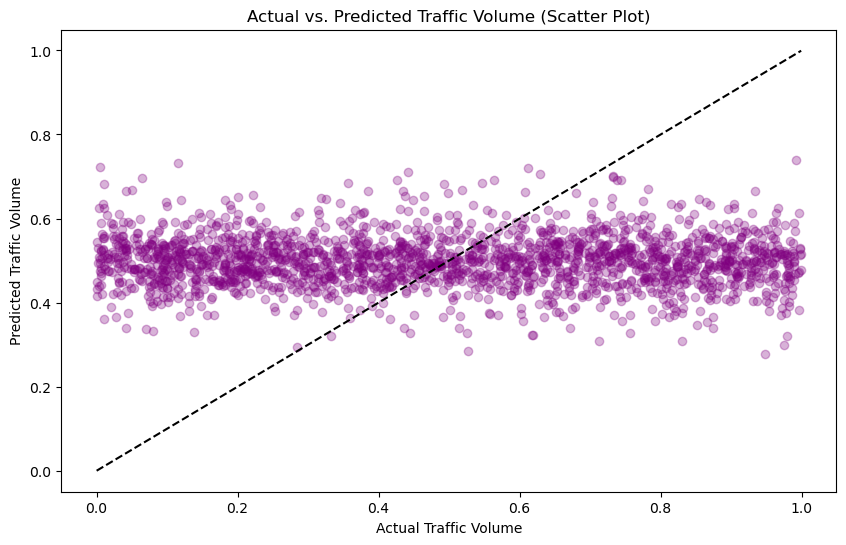

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='purple')  # Alpha for transparency on large datasets
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')  # Diagonal line
plt.xlabel('Actual Traffic Volume')
plt.ylabel('Predicted Traffic Volume')
plt.title('Actual vs. Predicted Traffic Volume (Scatter Plot)')
plt.show()
